# Import Libraries and Check Device

In [1]:
import os
import json
import random
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as transforms
from tqdm import tqdm

# Check the available device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Info] Using device: {device}")

[Info] Using device: cuda


# Download and Extract Dataset/large

In [2]:
# GitHub repository URL
repo_url = "https://github.com/caochengrui/Object_Classification_and_Localiztion_on_Emoji_Dataset.git"
repo_dir = "./Object_Classification_and_Localiztion_on_Emoji_Dataset"

# Clone the repository if it hasn't been cloned yet
if not os.path.exists(repo_dir):
    print("[Info] Cloning repo...")
    !git clone "$repo_url" "$repo_dir" --depth=1
else:
    print("[Info] Repo already exists, skip cloning.")

# Copy the 'images' and 'annotations' folders from the repository to the current directory
if not os.path.exists("./images"):
    print("[Info] Copying images folder from repo...")
    !cp -r Object_Classification_and_Localiztion_on_Emoji_Dataset/Dataset/large/images ./
if not os.path.exists("./annotations"):
    print("[Info] Copying annotations folder from repo...")
    !cp -r Object_Classification_and_Localiztion_on_Emoji_Dataset/Dataset/large/annotations ./

# Unzip the train, validation, and test image archives
subsets = ["train", "val", "test"]
for subset in subsets:
    zip_path = f"./images/{subset}/{subset}_images.zip"
    if os.path.exists(zip_path):
        print(f"[Info] Unzipping {zip_path} ...")
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(f"./images/{subset}")
        print("Done.")
    else:
        print(f"[Warning] {zip_path} not found, please check your dataset structure.")

[Info] Cloning repo...
Cloning into './Object_Classification_and_Localiztion_on_Emoji_Dataset'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 58 (delta 8), reused 55 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 78.35 MiB | 17.03 MiB/s, done.
Resolving deltas: 100% (8/8), done.
[Info] Copying images folder from repo...
[Info] Copying annotations folder from repo...
[Info] Unzipping ./images/train/train_images.zip ...
Done.
[Info] Unzipping ./images/val/val_images.zip ...
Done.
[Info] Unzipping ./images/test/test_images.zip ...
Done.


# Define Constants

In [3]:
IMAGE_SIZE = 144
EMOJI_SIZE = 52
NUM_CLASSES = 9

# Create Custom Dataset

In [4]:
class SingleEmojiCocoDataset(Dataset):
    """
    Loads images from images/<subset>/*.jpg,
    and retrieves (class_id, bbox) from annotations/<subset>/<subset>.json in COCO format.
    Only single-object annotations are included => (category_id, bbox).
    Outputs: (image_tensor, class_label, coord_label)
             where coord_label = [row_norm, col_norm]
    """
    def __init__(self, subset="train", transform=None):
        super().__init__()
        self.subset = subset
        self.transform = transform

        # 1) Read COCO JSON annotations
        ann_path = os.path.join("annotations", subset, f"{subset}.json")
        with open(ann_path, "r", encoding="utf-8") as f:
            coco_data = json.load(f)

        self.image_infos = {img["id"]: img for img in coco_data["images"]}
        self.annotations = coco_data["annotations"]  # All annotations

        # Create a mapping from category_id to 0..8
        self.catId_to_label = {}
        for cat in coco_data["categories"]:
            # cat["id"] in [1..9], cat["name"] ~ 'happy' ...
            self.catId_to_label[cat["id"]] = cat["id"] - 1  # => 0..8

        # 2) Generate the list of samples
        #    For single-object detection, each image corresponds to 1 annotation
        self.samples = []
        for ann in self.annotations:
            img_id = ann["image_id"]
            cat_id = ann["category_id"]
            bbox = ann["bbox"]   # [x, y, w, h]
            # note x=col, y=row in typical COCO
            # bounding box pixel
            x, y, w, h = bbox

            row_norm = y / IMAGE_SIZE
            col_norm = x / IMAGE_SIZE

            class_label = self.catId_to_label[cat_id]

            # file_name
            img_info = self.image_infos[img_id]
            file_name = img_info["file_name"]

            self.samples.append({
                "img_path": os.path.join("images", subset, file_name),
                "class_label": class_label,
                "coord_label": [row_norm, col_norm]
            })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        record = self.samples[idx]
        img_path = record["img_path"]
        class_label = record["class_label"]
        coord_label = record["coord_label"]

        # 1) Load image
        image = Image.open(img_path).convert("RGB")  # => PIL Image
        # 2) Apply transforms (e.g., ToTensor)
        if self.transform:
            image = self.transform(image)
        else:
            # Default to tensor conversion
            image = transforms.ToTensor()(image)  # => (C,H,W), in [0,1]

        # 3) Return the processed data
        class_label_t = torch.tensor(class_label, dtype=torch.long)
        coord_label_t = torch.tensor(coord_label, dtype=torch.float32)
        return image, class_label_t, coord_label_t

# Prepare Data Loaders

In [5]:
# Define transformations for training, validation, and testing
train_transform = transforms.Compose([
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToTensor()
])

# Initialize datasets for training, validation, and testing
train_dataset = SingleEmojiCocoDataset(subset="train", transform=train_transform)
val_dataset = SingleEmojiCocoDataset(subset="val", transform=val_transform)
test_dataset = SingleEmojiCocoDataset(subset="test", transform=test_transform)

# Create data loaders with appropriate batch sizes and shuffling
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Print dataset sizes for verification
print(f"[Info] train_dataset size: {len(train_dataset)}")
print(f"[Info] val_dataset size:   {len(val_dataset)}")
print(f"[Info] test_dataset size:  {len(test_dataset)}")

[Info] train_dataset size: 11200
[Info] val_dataset size:   3200
[Info] test_dataset size:  1600


# Define Intersection over Union (IoU) Metric

In [6]:
class IoU:
    def __init__(self):
        self.reset()

    def reset(self):
        self.total_iou = 0.0
        self.num_examples = 0

    def update(self, y_true, y_pred):
        gt_x1 = y_true[:, 1] * IMAGE_SIZE
        gt_y1 = y_true[:, 0] * IMAGE_SIZE
        gt_x2 = gt_x1 + EMOJI_SIZE
        gt_y2 = gt_y1 + EMOJI_SIZE

        pred_x1 = y_pred[:, 1] * IMAGE_SIZE
        pred_y1 = y_pred[:, 0] * IMAGE_SIZE
        pred_x2 = pred_x1 + EMOJI_SIZE
        pred_y2 = pred_y1 + EMOJI_SIZE

        inter_x1 = torch.max(gt_x1, pred_x1)
        inter_y1 = torch.max(gt_y1, pred_y1)
        inter_x2 = torch.min(gt_x2, pred_x2)
        inter_y2 = torch.min(gt_y2, pred_y2)

        inter_w = (inter_x2 - inter_x1).clamp(min=0)
        inter_h = (inter_y2 - inter_y1).clamp(min=0)
        inter_area = inter_w * inter_h

        gt_area = (gt_x2 - gt_x1) * (gt_y2 - gt_y1)
        pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
        union_area = gt_area + pred_area - inter_area

        iou = torch.where(union_area > 0, inter_area / union_area, torch.zeros_like(union_area))
        self.total_iou += iou.sum().item()
        self.num_examples += y_true.size(0)

    def compute(self):
        if self.num_examples == 0:
            return 0
        return self.total_iou / self.num_examples

# Define the Model

In [7]:
class ObjectClassificationLocalizationModel(nn.Module):
    def __init__(self, num_classes=9):
        super(ObjectClassificationLocalizationModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(256 * 2 * 2, 256),
            nn.ReLU()
        )

        self.classifier = nn.Linear(256, num_classes)
        self.regressor = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc(x)
        class_output = self.classifier(x)
        coord_output = self.regressor(x)
        return class_output, coord_output

# Initialize the model and move it to the appropriate device
model = ObjectClassificationLocalizationModel(NUM_CLASSES).to(device)
print(model)

ObjectClassificationLocalizationModel(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): MaxPool2d(k

# Configure Training Parameters

In [8]:
# Define loss functions for classification and coordinate regression
criterion_class = nn.CrossEntropyLoss()
criterion_coord = nn.MSELoss()

# Define optimizers for different parts of the model
optimizer_shared = optim.Adam(list(model.features.parameters()) + list(model.fc.parameters()), lr=0.001)
optimizer_class  = optim.Adam(model.classifier.parameters(), lr=0.001)
optimizer_coord  = optim.Adam(model.regressor.parameters(), lr=0.001)

# Define learning rate schedulers based on validation metrics
scheduler_class = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_class, mode='max', factor=0.5, patience=3, verbose=True, min_lr=1e-6)
scheduler_coord = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_coord, mode='max', factor=0.5, patience=3, verbose=True, min_lr=1e-6)

# Early stopping parameters
early_stop_patience = 5
num_epochs = 50  # Adjust as needed
best_val_acc = 0.0
best_val_iou = 0.0
epochs_no_improve = 0

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Define Visualization Functions

In [9]:
def plot_bounding_box(image, gt_coords, pred_coords=None, norm=False):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image.astype('uint8'))
    draw = ImageDraw.Draw(image)

    gt_row, gt_col = gt_coords
    if norm:
        gt_row *= IMAGE_SIZE
        gt_col *= IMAGE_SIZE
    draw.rectangle([gt_col, gt_row, gt_col + EMOJI_SIZE, gt_row + EMOJI_SIZE],
                   outline='green', width=3)

    if pred_coords is not None:
        pred_row, pred_col = pred_coords
        if norm:
            pred_row *= IMAGE_SIZE
            pred_col *= IMAGE_SIZE
        draw.rectangle([pred_col, pred_row, pred_col + EMOJI_SIZE, pred_row + EMOJI_SIZE],
                       outline='red', width=3)

    return image

def visualize_predictions(model, loader, device, num_samples=4):
    model.eval()
    images, class_labels, coord_labels = next(iter(loader))
    images = images.to(device)
    class_labels = class_labels.to(device)
    coord_labels = coord_labels.to(device)

    with torch.no_grad():
        class_preds, coord_preds = model(images)
        class_pred_labels = torch.argmax(class_preds, dim=1)

    images_cpu = images.cpu().numpy().transpose(0, 2, 3, 1)
    class_labels_cpu = class_labels.cpu().numpy()
    class_pred_labels_cpu = class_pred_labels.cpu().numpy()
    coord_labels_cpu = coord_labels.cpu().numpy()
    coord_preds_cpu = coord_preds.cpu().numpy()

    fig, axs = plt.subplots(1, num_samples, figsize=(4*num_samples, 4))
    for i in range(num_samples):
        if i >= len(images_cpu):
            break

        img = (images_cpu[i]*255).astype('uint8')  # Restore visualization
        true_class = class_labels_cpu[i]
        pred_class = class_pred_labels_cpu[i]
        true_coord = coord_labels_cpu[i]
        pred_coord = coord_preds_cpu[i]

        img_with_boxes = plot_bounding_box(img, gt_coords=true_coord, pred_coords=pred_coord, norm=True)

        title_color = 'green' if (true_class == pred_class) else 'red'
        axs[i].imshow(img_with_boxes)
        axs[i].set_title(f"T:{true_class}, P:{pred_class}", color=title_color)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

# Train the Model

[Val]   Epoch 1/50: 100%|██████████| 200/200 [00:03<00:00, 64.67it/s]


Epoch [1/50]
Train Class Loss: 0.2051 | Train Coord Loss: 0.0030 | Train Acc: 0.9262 | Train IoU: 0.6760
Val   Class Loss: 0.0015 | Val   Coord Loss: 0.0011 | Val   Acc: 0.9994 | Val   IoU: 0.7632


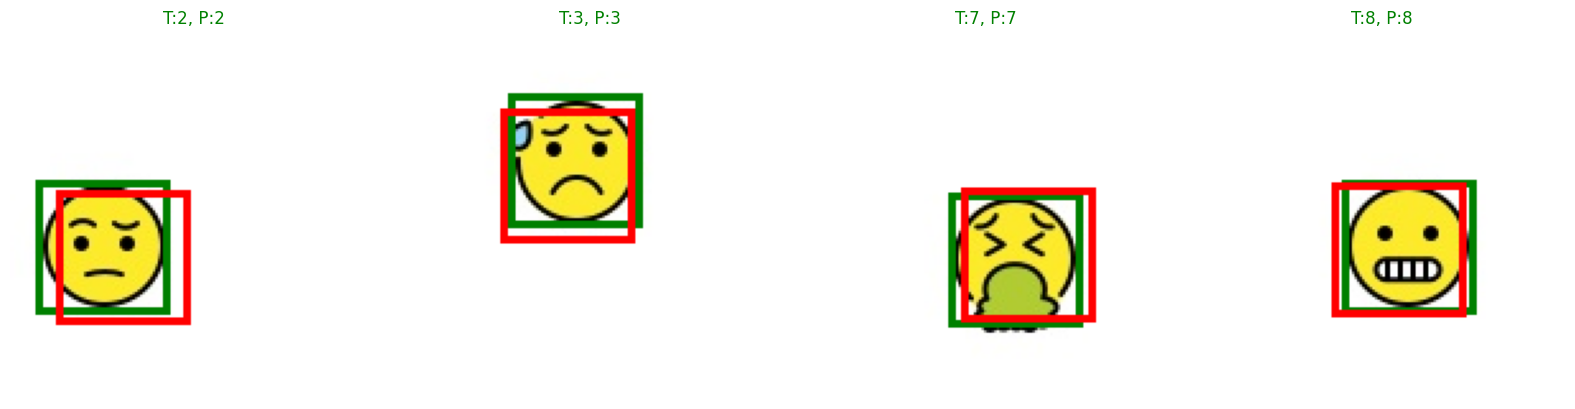

[Val]   Epoch 2/50: 100%|██████████| 200/200 [00:03<00:00, 58.55it/s]


Epoch [2/50]
Train Class Loss: 0.0453 | Train Coord Loss: 0.0013 | Train Acc: 0.9902 | Train IoU: 0.7535
Val   Class Loss: 0.0003 | Val   Coord Loss: 0.0013 | Val   Acc: 1.0000 | Val   IoU: 0.7511


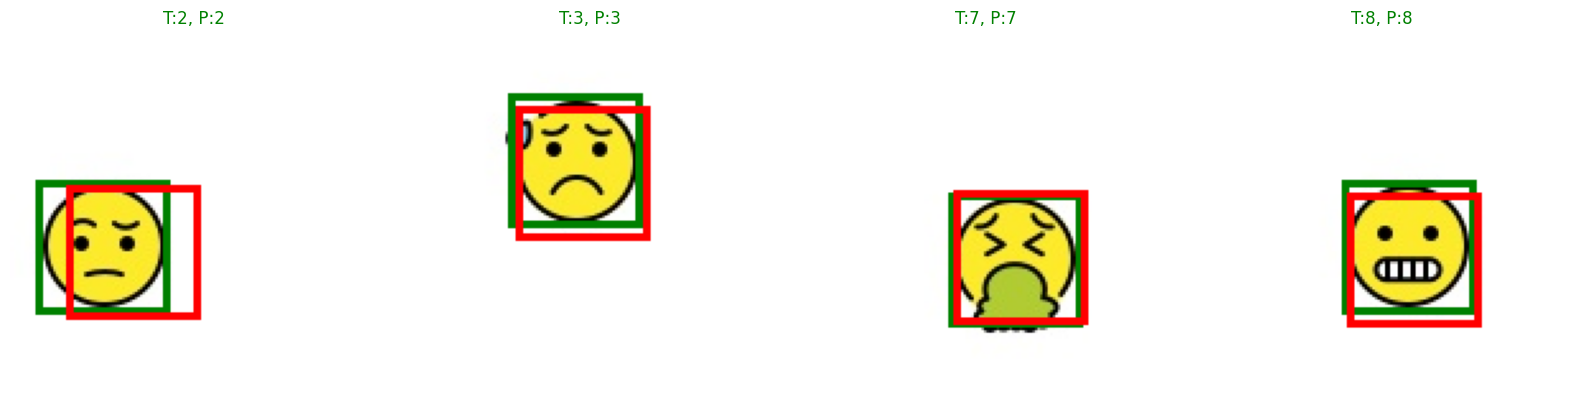

[Val]   Epoch 3/50: 100%|██████████| 200/200 [00:02<00:00, 68.44it/s]


Epoch [3/50]
Train Class Loss: 0.0185 | Train Coord Loss: 0.0010 | Train Acc: 0.9964 | Train IoU: 0.7756
Val   Class Loss: 0.0000 | Val   Coord Loss: 0.0005 | Val   Acc: 1.0000 | Val   IoU: 0.8343


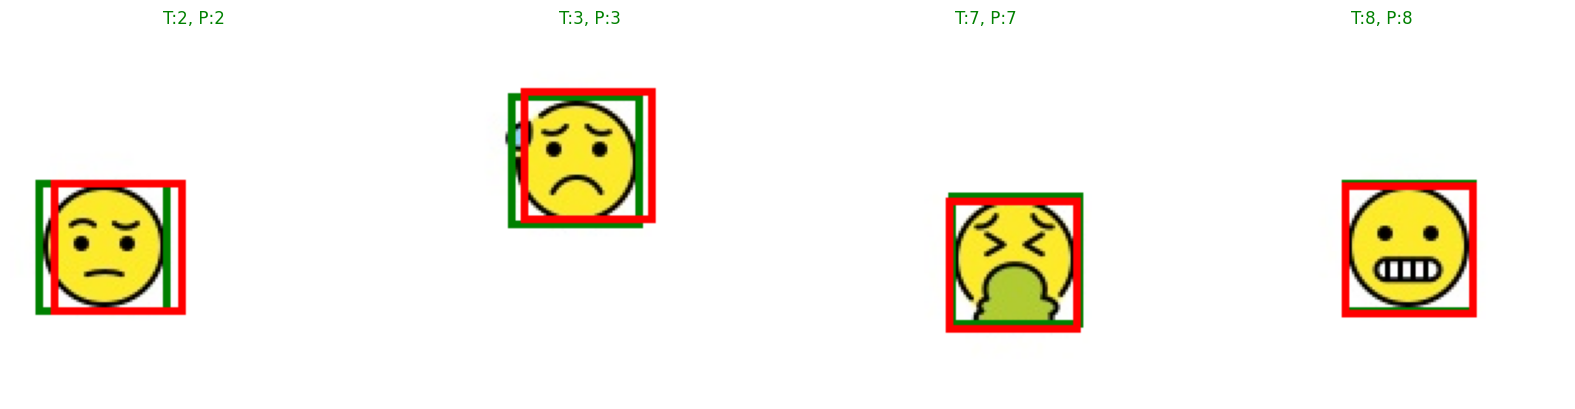

[Val]   Epoch 4/50: 100%|██████████| 200/200 [00:03<00:00, 50.39it/s]


Epoch [4/50]
Train Class Loss: 0.0034 | Train Coord Loss: 0.0006 | Train Acc: 0.9991 | Train IoU: 0.8146
Val   Class Loss: 0.0000 | Val   Coord Loss: 0.0005 | Val   Acc: 1.0000 | Val   IoU: 0.8579


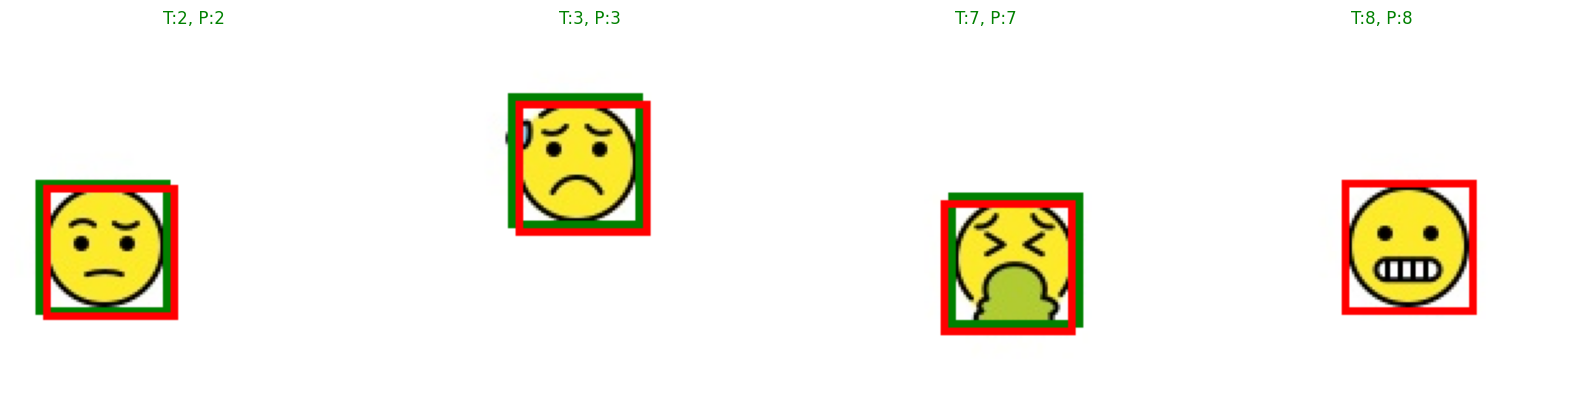

[Val]   Epoch 5/50: 100%|██████████| 200/200 [00:03<00:00, 65.14it/s]


Epoch [5/50]
Train Class Loss: 0.0577 | Train Coord Loss: 0.0012 | Train Acc: 0.9908 | Train IoU: 0.7661
Val   Class Loss: 0.0000 | Val   Coord Loss: 0.0006 | Val   Acc: 1.0000 | Val   IoU: 0.8161


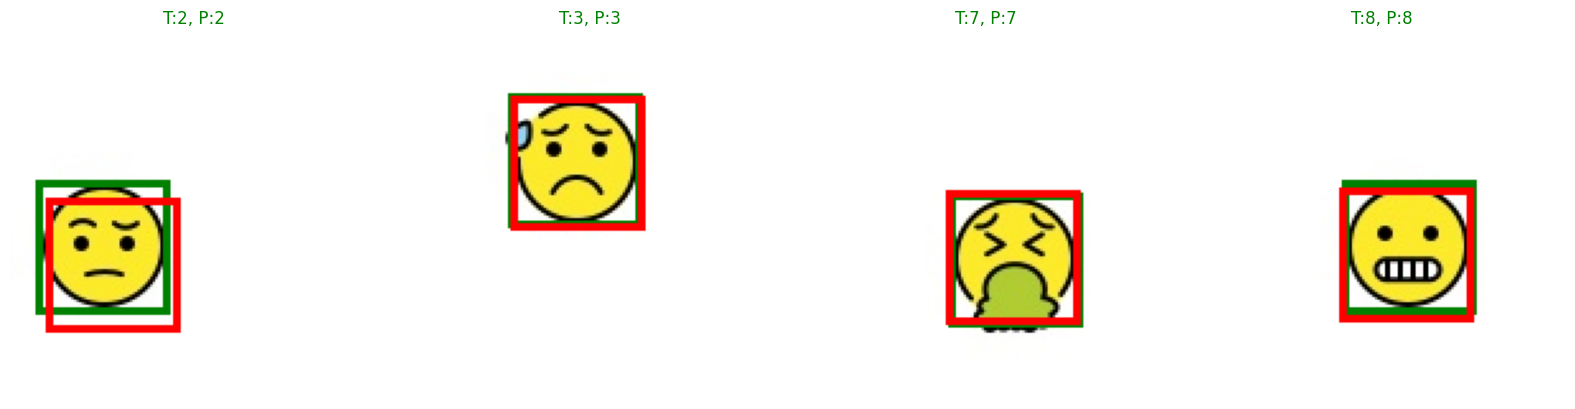

[Val]   Epoch 6/50: 100%|██████████| 200/200 [00:03<00:00, 65.92it/s]


Epoch [6/50]
Train Class Loss: 0.0005 | Train Coord Loss: 0.0006 | Train Acc: 0.9998 | Train IoU: 0.8188
Val   Class Loss: 0.0000 | Val   Coord Loss: 0.0004 | Val   Acc: 1.0000 | Val   IoU: 0.8427


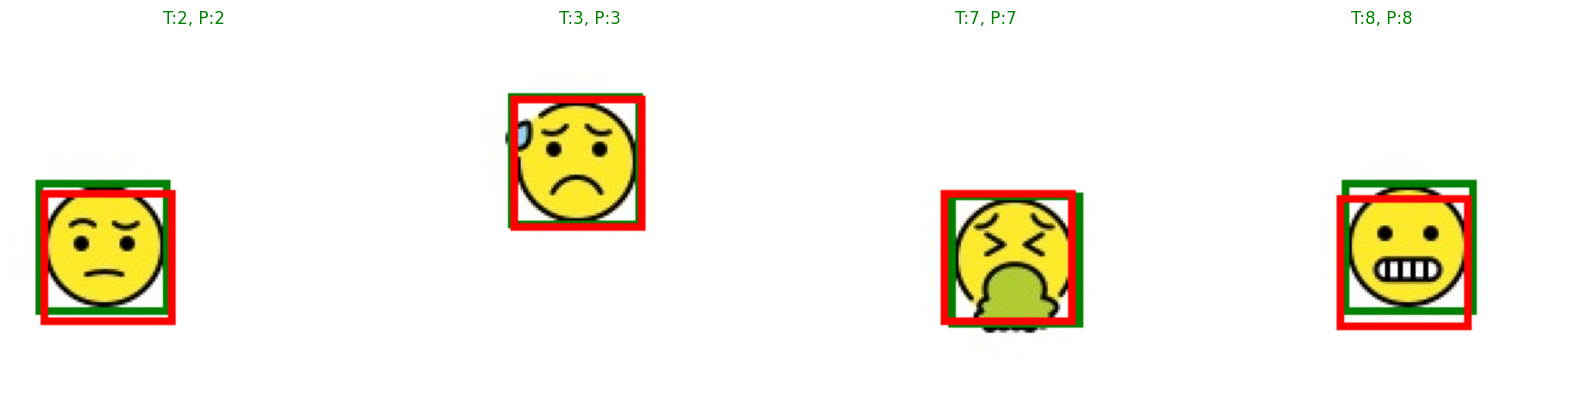

[Val]   Epoch 7/50: 100%|██████████| 200/200 [00:04<00:00, 47.18it/s]


Epoch [7/50]
Train Class Loss: 0.0002 | Train Coord Loss: 0.0004 | Train Acc: 0.9999 | Train IoU: 0.8452
Val   Class Loss: 0.0000 | Val   Coord Loss: 0.0004 | Val   Acc: 1.0000 | Val   IoU: 0.8495


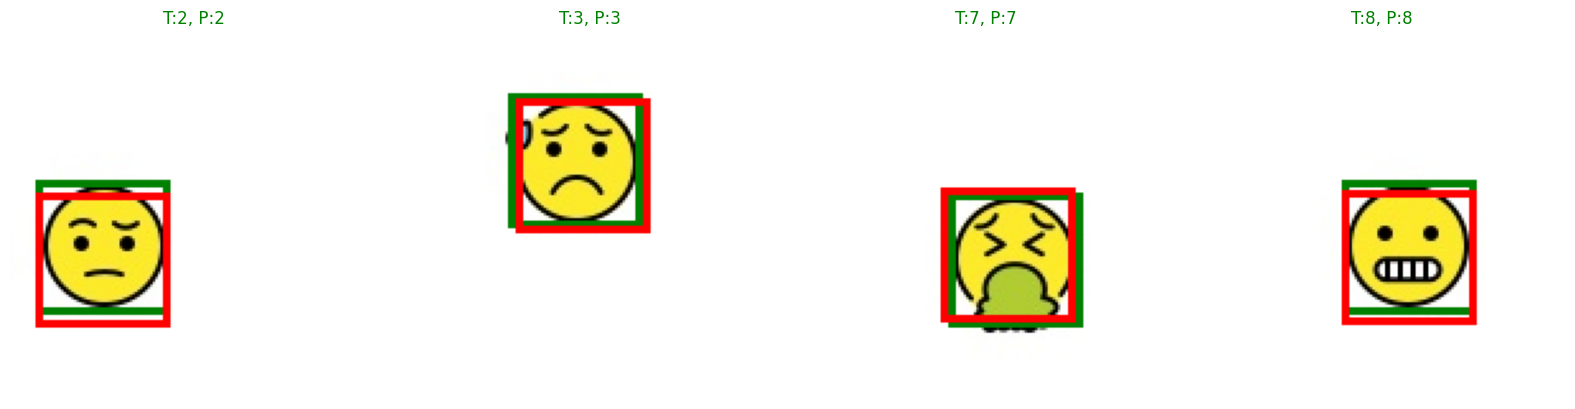

[Val]   Epoch 8/50: 100%|██████████| 200/200 [00:03<00:00, 64.53it/s]


Epoch [8/50]
Train Class Loss: 0.0181 | Train Coord Loss: 0.0008 | Train Acc: 0.9965 | Train IoU: 0.8003
Val   Class Loss: 0.0000 | Val   Coord Loss: 0.0008 | Val   Acc: 1.0000 | Val   IoU: 0.7993


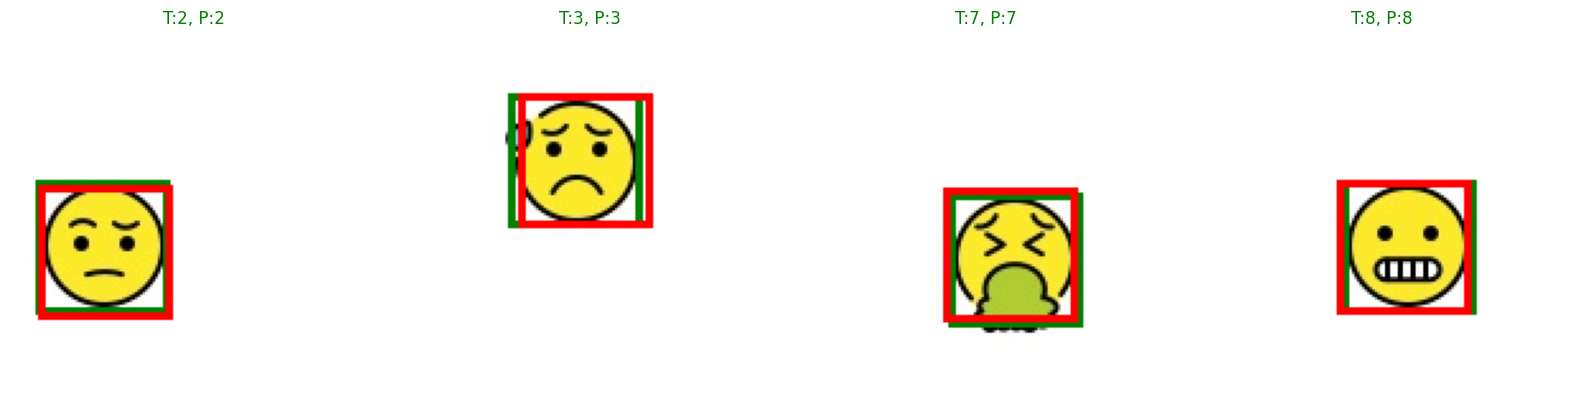

[Val]   Epoch 9/50: 100%|██████████| 200/200 [00:03<00:00, 62.27it/s]


Epoch [9/50]
Train Class Loss: 0.0216 | Train Coord Loss: 0.0008 | Train Acc: 0.9967 | Train IoU: 0.8020
Val   Class Loss: 0.0000 | Val   Coord Loss: 0.0007 | Val   Acc: 1.0000 | Val   IoU: 0.8240
Early stopping!

Best: Epoch [4/50]
      Train Class Loss: 0.0034 | Train Coord Loss: 0.0006 | Train Acc: 0.9991 | Train IoU: 0.8146
      Val   Class Loss: 0.0000 | Val   Coord Loss: 0.0005 | Val   Acc: 1.0000 | Val   IoU: 0.8579


In [10]:
# variables to store best epoch info
best_epoch = 0
best_train_class_loss = float('inf')
best_train_coord_loss = float('inf')
best_train_class_acc = 0.0
best_train_iou = 0.0
best_val_class_loss = float('inf')
best_val_coord_loss = float('inf')
best_val_class_acc = 0.0
best_val_iou_metric = 0.0

# Record the start time of training
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    train_class_loss = 0.0
    train_coord_loss = 0.0
    train_class_correct = 0
    train_iou_metric = IoU()

    for images_batch, class_labels_batch, coord_labels_batch in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}"):
        images_batch = images_batch.to(device)
        class_labels_batch = class_labels_batch.to(device)
        coord_labels_batch = coord_labels_batch.to(device)

        # Classification step
        optimizer_shared.zero_grad()
        optimizer_class.zero_grad()

        outputs_class, _ = model(images_batch)
        loss_class = criterion_class(outputs_class, class_labels_batch)
        loss_class.backward()
        optimizer_shared.step()
        optimizer_class.step()

        # Coordinate regression step
        optimizer_shared.zero_grad()
        optimizer_coord.zero_grad()

        _, outputs_coord = model(images_batch)
        loss_coord = criterion_coord(outputs_coord, coord_labels_batch)
        loss_coord.backward()
        optimizer_shared.step()
        optimizer_coord.step()

        train_class_loss += loss_class.item() * images_batch.size(0)
        train_coord_loss += loss_coord.item() * images_batch.size(0)

        preds = torch.argmax(outputs_class, dim=1)
        train_class_correct += (preds == class_labels_batch).sum().item()

        train_iou_metric.update(coord_labels_batch, outputs_coord)

    total_train_samples = len(train_dataset)
    epoch_class_loss = train_class_loss / total_train_samples
    epoch_coord_loss = train_coord_loss / total_train_samples
    epoch_class_acc = train_class_correct / total_train_samples
    epoch_iou = train_iou_metric.compute()

    model.eval()
    val_class_loss = 0.0
    val_coord_loss = 0.0
    val_class_correct = 0
    val_iou_metric = IoU()

    with torch.no_grad():
        for images_batch, class_labels_batch, coord_labels_batch in tqdm(val_loader, desc=f"[Val]   Epoch {epoch+1}/{num_epochs}"):
            images_batch = images_batch.to(device)
            class_labels_batch = class_labels_batch.to(device)
            coord_labels_batch = coord_labels_batch.to(device)

            outputs_class, outputs_coord = model(images_batch)
            loss_class = criterion_class(outputs_class, class_labels_batch)
            loss_coord = criterion_coord(outputs_coord, coord_labels_batch)

            val_class_loss += loss_class.item() * images_batch.size(0)
            val_coord_loss += loss_coord.item() * images_batch.size(0)

            preds = torch.argmax(outputs_class, dim=1)
            val_class_correct += (preds == class_labels_batch).sum().item()

            val_iou_metric.update(coord_labels_batch, outputs_coord)

    total_val_samples = len(val_dataset)
    val_epoch_class_loss = val_class_loss / total_val_samples
    val_epoch_coord_loss = val_coord_loss / total_val_samples
    val_epoch_class_acc = val_class_correct / total_val_samples
    val_epoch_iou = val_iou_metric.compute()

    scheduler_class.step(val_epoch_class_acc)
    scheduler_coord.step(val_epoch_iou)

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"Train Class Loss: {epoch_class_loss:.4f} | Train Coord Loss: {epoch_coord_loss:.4f} "
          f"| Train Acc: {epoch_class_acc:.4f} | Train IoU: {epoch_iou:.4f}")
    print(f"Val   Class Loss: {val_epoch_class_loss:.4f} | Val   Coord Loss: {val_epoch_coord_loss:.4f} "
          f"| Val   Acc: {val_epoch_class_acc:.4f} | Val   IoU: {val_epoch_iou:.4f}")

    improved = False
    # Check if IoU improved
    if val_epoch_iou > best_val_iou:
        best_val_iou = val_epoch_iou
        improved = True
    # Check if Accuracy improved
    if val_epoch_class_acc > best_val_acc:
        best_val_acc = val_epoch_class_acc
        improved = True

    # If either improved, record the best epoch stats and save model
    if improved:
        best_epoch = epoch + 1
        best_train_class_loss = epoch_class_loss
        best_train_coord_loss = epoch_coord_loss
        best_train_class_acc = epoch_class_acc
        best_train_iou = epoch_iou
        best_val_class_loss = val_epoch_class_loss
        best_val_coord_loss = val_epoch_coord_loss
        best_val_class_acc = val_epoch_class_acc
        best_val_iou_metric = val_epoch_iou
        torch.save(model.state_dict(), "best_model.pth")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print("Early stopping!")
            break

    visualize_predictions(model, val_loader, device, num_samples=4)

end_time = time.time()
total_time = end_time - start_time

# After the training loop, print the best epoch information
print(f"\nBest: Epoch [{best_epoch}/{num_epochs}]")
print(f"      Train Class Loss: {best_train_class_loss:.4f} | Train Coord Loss: {best_train_coord_loss:.4f} "
      f"| Train Acc: {best_train_class_acc:.4f} | Train IoU: {best_train_iou:.4f}")
print(f"      Val   Class Loss: {best_val_class_loss:.4f} | Val   Coord Loss: {best_val_coord_loss:.4f} "
      f"| Val   Acc: {best_val_class_acc:.4f} | Val   IoU: {best_val_iou_metric:.4f}")

# Evaluate the Model on Test Data

In [11]:
print("\n============== Results ==============")
# Add weights_only=True to eliminate FutureWarning
weights = torch.load("best_model.pth", weights_only=True)
model.load_state_dict(weights)
model.eval()

test_class_loss = 0.0
test_coord_loss = 0.0
test_class_correct = 0
test_iou_metric = IoU()

with torch.no_grad():
    for images_batch, class_labels_batch, coord_labels_batch in tqdm(test_loader, desc="[Test] Evaluating"):
        images_batch = images_batch.to(device)
        class_labels_batch = class_labels_batch.to(device)
        coord_labels_batch = coord_labels_batch.to(device)

        outputs_class, outputs_coord = model(images_batch)
        loss_class = criterion_class(outputs_class, class_labels_batch)
        loss_coord = criterion_coord(outputs_coord, coord_labels_batch)

        test_class_loss += loss_class.item() * images_batch.size(0)
        test_coord_loss += loss_coord.item() * images_batch.size(0)

        preds = torch.argmax(outputs_class, dim=1)
        test_class_correct += (preds == class_labels_batch).sum().item()

        test_iou_metric.update(coord_labels_batch, outputs_coord)

total_test_samples = len(test_dataset)
test_epoch_class_loss = test_class_loss / total_test_samples
test_epoch_coord_loss = test_coord_loss / total_test_samples
test_epoch_class_acc = test_class_correct / total_test_samples
test_epoch_iou = test_iou_metric.compute()

print(f"\nTest Class Loss (CE):  {test_epoch_class_loss:.4f}")
print(f"Test Coord Loss (MSE): {test_epoch_coord_loss:.4f}")
print(f"Test Class Accuracy:   {test_epoch_class_acc:.4f}")
print(f"Test Coord IoU:        {test_epoch_iou:.4f}")

# Output total training time in minutes and seconds
minutes, seconds = divmod(int(total_time), 60)
print(f"Total Training Time: {minutes} minutes {seconds} seconds")


============== Results ==============


[Test] Evaluating: 100%|██████████| 100/100 [00:01<00:00, 63.59it/s]


Test Class Loss (CE):  0.0000
Test Coord Loss (MSE): 0.0004
Test Class Accuracy:   1.0000
Test Coord IoU:        0.8589
Total Training Time: 3 minutes 17 seconds
